In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.cuda.amp as amp
import os
import shutil
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
import gc
import IPython
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

checkpoint_dir = "model_checkpoints"
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

In [2]:
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
def check_and_clear_cuda_memory():
    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"Before Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    IPython.display.clear_output(wait=True)  # Clear Jupyter output

    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"After Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

check_and_clear_cuda_memory()

After Clearing - Free memory: 11034.06 MB / 11172.19 MB


In [5]:
data_dir = "tiny-imagenet-200"

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])


test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from PIL import Image
img_path = "tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG"
img = Image.open(img_path)
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [8]:
#subset_size = 8000  # Adjust size , max is 100000
#train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
#indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)  # Fixed subset indices
#train_dataset = torch.utils.data.Subset(train_dataset_full, indices)
#train_dataset = torch.utils.data.Subset(train_dataset_full, range(subset_size))
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

In [9]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,  pin_memory=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=True,  drop_last=True)
    return train_loader, test_loader

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 200)

        self.alpha_conv = nn.Parameter(torch.full((1,), 0.01))  # Learnable α for conv layers
        self.alpha_fc = nn.Parameter(torch.full((1,), 0.01))

    def forward(self, x):
        x = F.prelu(self.bn1(self.conv1(x)), self.alpha_conv)
        x = F.prelu(self.bn2(self.conv2(x)), self.alpha_conv)

        x = F.prelu(self.bn3(self.conv3(x)), self.alpha_conv)
        x = F.prelu(self.bn4(self.conv4(x)), self.alpha_conv)

        x = F.prelu(self.bn5(self.conv5(x)), self.alpha_conv)
        x = F.prelu(self.bn6(self.conv6(x)), self.alpha_conv)

        x = F.prelu(self.bn7(self.conv7(x)), self.alpha_conv)
        x = F.prelu(self.bn8(self.conv8(x)), self.alpha_conv)

        x = self.adaptive_pool(x)
        x = torch.flatten(x, start_dim=1)
        
        x = self.dropout(F.prelu(self.fc1(x), self.alpha_fc))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Initialize model with Kaiming initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

CNN().to(device)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn6)

In [11]:
def evaluate_model(model, data_loader, dataset_name="Validation"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1) #Accuracy computation
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')
    return accuracy

train_acc_list, test_acc_list, train_loss_list, test_loss_list, epoch_listings = [], [], [], [], []

In [12]:
train_acc_list, test_acc_list, train_loss_list, test_loss_list, epoch_listings = [], [], [], [], []

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
train_loader, test_loader = create_dataloaders(256)  # Assume a function for this

num_epochs = 50
min_test_loss = float('inf')

for epoch in range(num_epochs):
    epoch_listings.append(epoch)
    model.train()
    running_loss_train = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    train_acc_list.append(train_accuracy)
    train_loss_list.append(epoch_loss_train)

    # test phase
    model.eval()
    running_loss_test = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_test += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    epoch_loss_test = running_loss_test / len(test_loader.dataset)
    test_accuracy = correct_test / total_test

    test_acc_list.append(test_accuracy)
    test_loss_list.append(epoch_loss_test)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}\n')

    # Early Stopping Check
    if epoch_loss_test < min_test_loss:
        min_test_loss = epoch_loss_test
        best_model = model
        print("Best model")
        
print("Training complete.")

Epoch 1/50, Train Loss: 5.1526, Test Loss: 5.5776
Train Accuracy: 0.0188, Test Accuracy: 0.0003

Best model
Epoch 2/50, Train Loss: 4.9761, Test Loss: 6.0109
Train Accuracy: 0.0290, Test Accuracy: 0.0009

Epoch 3/50, Train Loss: 4.8306, Test Loss: 6.3533
Train Accuracy: 0.0398, Test Accuracy: 0.0018

Epoch 4/50, Train Loss: 4.7134, Test Loss: 7.1188
Train Accuracy: 0.0502, Test Accuracy: 0.0015

Epoch 5/50, Train Loss: 4.6147, Test Loss: 7.0813
Train Accuracy: 0.0587, Test Accuracy: 0.0050

Epoch 6/50, Train Loss: 4.5641, Test Loss: 7.4502
Train Accuracy: 0.0644, Test Accuracy: 0.0053

Epoch 7/50, Train Loss: 4.5205, Test Loss: 8.2023
Train Accuracy: 0.0690, Test Accuracy: 0.0041

Epoch 8/50, Train Loss: 4.4773, Test Loss: 7.6717
Train Accuracy: 0.0752, Test Accuracy: 0.0054

Epoch 9/50, Train Loss: 4.4309, Test Loss: 8.2379
Train Accuracy: 0.0797, Test Accuracy: 0.0047

Epoch 10/50, Train Loss: 4.4086, Test Loss: 7.5207
Train Accuracy: 0.0820, Test Accuracy: 0.0055

Epoch 11/50, Train

In [13]:
# Training Evaluation
evaluate_model(best_model, train_loader, "Training")

# Validation Evaluation
evaluate_model(best_model, test_loader, "Testing")

Training Accuracy: 0.1214
Testing Accuracy: 0.0057


0.005709134615384615

In [14]:
final_model_path = os.path.join(checkpoint_dir, 'tiny_imagenet_cnn.pth')
torch.save(best_model.state_dict(), final_model_path)

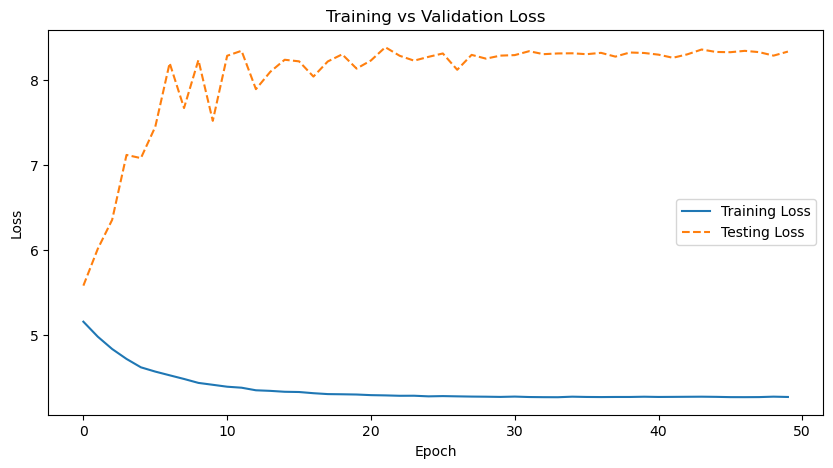

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_listings, train_loss_list, label='Training Loss')
plt.plot(epoch_listings, test_loss_list, label='Testing Loss', linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

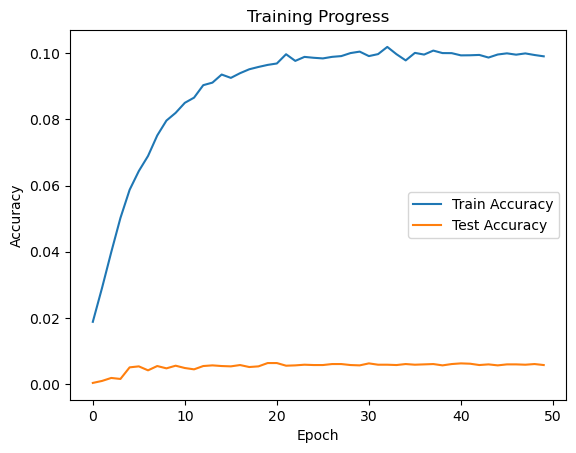

In [16]:
plt.plot(epoch_listings, train_acc_list, label="Train Accuracy")
plt.plot(epoch_listings, test_acc_list, label="Test Accuracy")
#plt.plot(epoch_listings, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()